## **Introduction**

Mosquito-borne diseases, such as malaria, dengue, and Zika, pose significant public health threats globally, affecting millions of individuals annually—especially in tropical regions. Effective mosquito species identification is crucial for implementing timely vector control measures and preventing outbreaks. Traditionally, species identification relies on human expertise in entomology, which is both time-consuming and prone to human error.

Recent advances in computer vision and deep learning have revolutionized image recognition, offering automated and highly accurate solutions for tasks such as species classification. Leveraging these technologies, researchers are developing machine learning frameworks to classify mosquitoes from images—particularly those captured on human skin—for real-time vector identification and control.

In this project, **MobileNet** model is developed to classify six different mosquito classes with the goal of supporting accurate and efficient species identification for improved disease prevention.


## **Motivation**

Accurately identifying mosquito species is challenging because of subtle visual differences, which can be difficult for humans to distinguish. Traditional methods like measuring wing-flapping frequency are limited and not scalable. As image classification continues to improve through deep learning, there is growing potential to develop automated systems that assist in mosquito species recognition, ultimately contributing to better disease prevention.

## **Problem Statement**

Mosquitoes pose substantial threat to public health resulting in million number of deaths worldwide every year. They act as the vectors responsible for diseases. The harmful mosquito species are contained in the genera Aedes, Anopheles and Culex. Since the differences between species are trivial for human vision, the current prevailing approach for identifying mosquito's species is based on recording the frequency of wing flapping, image classification of mosquitos is still a developing problem that requiring contributions.

## **Data Source**
The dataset used in this project consists of **RGB images of mosquitoes**, specifically collected for training and evaluating recognition systems that identify mosquitoes on human skin. The images were sourced from a **WHO-accredited breeding laboratory** in 2022, ensuring accurate species labeling and reliable annotations. The dataset includes **three mosquito species** which are ***Aedes aegypti, Aedes albopictus, and Culex quinquefasciatus*** and each captured in two physical conditions: ***normal landing and smashed***. This results in a total of six well-defined classes, making the dataset highly suitable for supervised learning tasks.

## **Code Implementation**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from collections import defaultdict
import os

In [2]:
# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data directories
dataset_dir = 'Mosquito-on-human-skin'
train_dir = os.path.join(dataset_dir, 'data_splitting/Train')
test_dir = os.path.join(dataset_dir, 'data_splitting/Test')

# Get class names
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)
print(f"Classes: {class_names}")
print(f"Number of classes: {num_classes}")

Using device: cpu
Classes: ['Culex landing', 'Culex smashed', 'aegypti landing', 'aegypti smashed', 'albopictus landing', 'albopictus smashed']
Number of classes: 6


## **Preporcessing**

During the data preprocessing stage, two different transformation pipelines were employed, one for the training set and the other for the test/validation set.

When handling test and verification data, only essential basic pre - processing steps such as unifying image sizes and normalization are retained.


In [3]:
# Data transforms for MobileNet (224x224 input)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)), #reszie all images to standard MobileNet input size
    transforms.RandomHorizontalFlip(p=0.5), #50% prob to flip images horizontally
    transforms.RandomVerticalFlip(p=0.3), #30% probability to flip images vertically
    transforms.RandomRotation(degrees=10), #Slightly rotates images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #Randomly adjusts brightness, dcontrast, saturation and hue
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #Using ImageNet's mean and standard deviation to standardize pixel values
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
trainset = datasets.ImageFolder(root=train_dir, transform=transform_train)
testset = datasets.ImageFolder(root=test_dir, transform=transform_test)

# Split training data into train and validation
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])
#split training set into 80% training and 20% validation

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(testset)}")

Training samples: 3360
Validation samples: 840
Test samples: 1799


## **Model Design**

### **Depthwise Separable Convolution**

Replaces standard convolution with depthwise + pointwise convolutions to significantly reduce parameters and computations

In [ ]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        
        # Depthwise convolution: applies a 3x3 filter per input channel
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, 
            kernel_size=3, stride=stride, padding=1, 
            groups=in_channels, bias=False
        )
        self.bn1 = nn.BatchNorm2d(in_channels)
        
        # Pointwise convolution: 1x1 convolution to combine features
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, 
            kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        # Depthwise convolution
        x = self.depthwise(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        # Pointwise convolution
        x = self.pointwise(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        return x

## **MobileNet**

The MobileNet model starts with a typical 3×3 convolutional layer, batch normalization, and ReLU activation to extract low level features from the input images. Then, it stacks thirteen depthwise separable convolutional blocks, each of which comprises a depthwise 3×3 convolution followed by a pointwise 1×1 convolution, with batch normalization and ReLU after each operation. It applies a dropout layer to avoid overfitting after global average pooling and sends the resulting feature vector through a fully connected layer to generate the final class logits. 

In [ ]:
class MobileNet(nn.Module):
    def __init__(self, num_classes=6, width_multiplier=1.0):
        super(MobileNet, self).__init__()
        
        # First standard 3x3 convolution layer: 3 input channels to 32 output channels
        self.conv1 = nn.Conv2d(3, int(32 * width_multiplier), kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(int(32 * width_multiplier))
        
        # Depthwise separable convolution layers (core of MobileNet)： 13layers
        self.layers = nn.ModuleList([
            # (in_channels, out_channels, stride)
            DepthwiseSeparableConv(int(32 * width_multiplier), int(64 * width_multiplier), 1),
            DepthwiseSeparableConv(int(64 * width_multiplier), int(128 * width_multiplier), 2),
            DepthwiseSeparableConv(int(128 * width_multiplier), int(128 * width_multiplier), 1),
            DepthwiseSeparableConv(int(128 * width_multiplier), int(256 * width_multiplier), 2),
            DepthwiseSeparableConv(int(256 * width_multiplier), int(256 * width_multiplier), 1),
            DepthwiseSeparableConv(int(256 * width_multiplier), int(512 * width_multiplier), 2),
            
            # 5 layers with 512 filters
            DepthwiseSeparableConv(int(512 * width_multiplier), int(512 * width_multiplier), 1),
            DepthwiseSeparableConv(int(512 * width_multiplier), int(512 * width_multiplier), 1),
            DepthwiseSeparableConv(int(512 * width_multiplier), int(512 * width_multiplier), 1),
            DepthwiseSeparableConv(int(512 * width_multiplier), int(512 * width_multiplier), 1),
            DepthwiseSeparableConv(int(512 * width_multiplier), int(512 * width_multiplier), 1),
            
            DepthwiseSeparableConv(int(512 * width_multiplier), int(1024 * width_multiplier), 2),
            DepthwiseSeparableConv(int(1024 * width_multiplier), int(1024 * width_multiplier), 1),
        ])
        
        # Global average pooling and classifier: 20% dropout for regularization, a linear layer for classification(1024 -> num_classes)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(int(1024 * width_multiplier), num_classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using Xavier/He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # First standard convolution
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Depthwise separable convolutions
        for layer in self.layers:
            x = layer(x)
        
        # Global average pooling and classification
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

# Create model instance
model = MobileNet(num_classes=num_classes, width_multiplier=1.0).to(device)

# Test the model
test_input = torch.randn(1, 3, 224, 224).to(device)
test_output = model(test_input)
print(f"Model output shape: {test_output.shape}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * 4 for p in model.parameters()) / (1024**2):.1f} MB")

Model output shape: torch.Size([1, 6])
Number of parameters: 3,213,126
Model size: 12.3 MB


The above output is **Model Testing and Parameter Count**

Creates a MobileNet instance with num_classes (from dataset) and moves it to the device.
Tests with a random input (1x3x224x224) to ensure the model produces the correct output shape (1xnum_classes).
Calculates and prints the total number of parameters and model size in MB.

In [ ]:
# Training setup
criterion = nn.CrossEntropyLoss() #Combines LogSoftmax and Negative Log-Likelihood loss
#Converts model logits to probabilities and computes the negative log-likelihood of the true class, penalizing incorrect predictions.
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

def evaluate_model(model, dataloader, criterion, device):
    """Evaluate model performance"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def train_mobilenet(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    """Train the MobileNet model"""
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Print training progress every 20 batches
            if batch_idx % 20 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}')
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        # Validation phase
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step()
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'  Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
        print('-' * 50)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_mobilenet_mosquito.pth')
            print(f'New best model saved with validation accuracy: {val_acc:.2f}%')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [7]:
# Train the custom MobileNet model
num_epochs = 25
print("Starting Custom MobileNet Training...")
print(f"Training for {num_epochs} epochs")
print(f"Class names: {class_names}")
print("=" * 60)

train_losses, val_losses, train_accuracies, val_accuracies = train_mobilenet(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device
)

Starting Custom MobileNet Training...
Training for 25 epochs
Class names: ['Culex landing', 'Culex smashed', 'aegypti landing', 'aegypti smashed', 'albopictus landing', 'albopictus smashed']
Epoch 1/25, Batch 0/105, Loss: 1.7859
Epoch 1/25, Batch 20/105, Loss: 1.6758
Epoch 1/25, Batch 40/105, Loss: 1.5566
Epoch 1/25, Batch 60/105, Loss: 1.3847
Epoch 1/25, Batch 80/105, Loss: 1.3963
Epoch 1/25, Batch 100/105, Loss: 1.2063
Epoch 1/25:
  Train Loss: 1.5430, Train Acc: 36.93%
  Val Loss: 1.3246, Val Acc: 44.52%
  Learning Rate: 0.001000
--------------------------------------------------
New best model saved with validation accuracy: 44.52%
Epoch 2/25, Batch 0/105, Loss: 1.2551
Epoch 2/25, Batch 20/105, Loss: 1.1724
Epoch 2/25, Batch 40/105, Loss: 1.1255
Epoch 2/25, Batch 60/105, Loss: 1.2286
Epoch 2/25, Batch 80/105, Loss: 1.3147
Epoch 2/25, Batch 100/105, Loss: 1.0761
Epoch 2/25:
  Train Loss: 1.2251, Train Acc: 51.55%
  Val Loss: 1.3138, Val Acc: 51.31%
  Learning Rate: 0.001000
--------

## **Results visualization**

The MobileNet model has a test accuracy of 88.33%. Training curves, confusion matrix and bar chart—are used to visualize the performance of the network in-depth. From these visualizations, it is evident that the Culex landing and Culex smashed classes are predicted with high accuracy, up to 94.00% and 98.00%, respectively. The aegypti smashed class, on the other hand, has poorer performance, with a classification accuracy of only 74.00%, which may be caused by confusion with the albopictus smashed class, as suggested by the confusion matrix. The other three classes (aegypti landing, albopictus landing, and albopictus smashed) have good performance, with accuracies between 85.28% and 91.33%. 

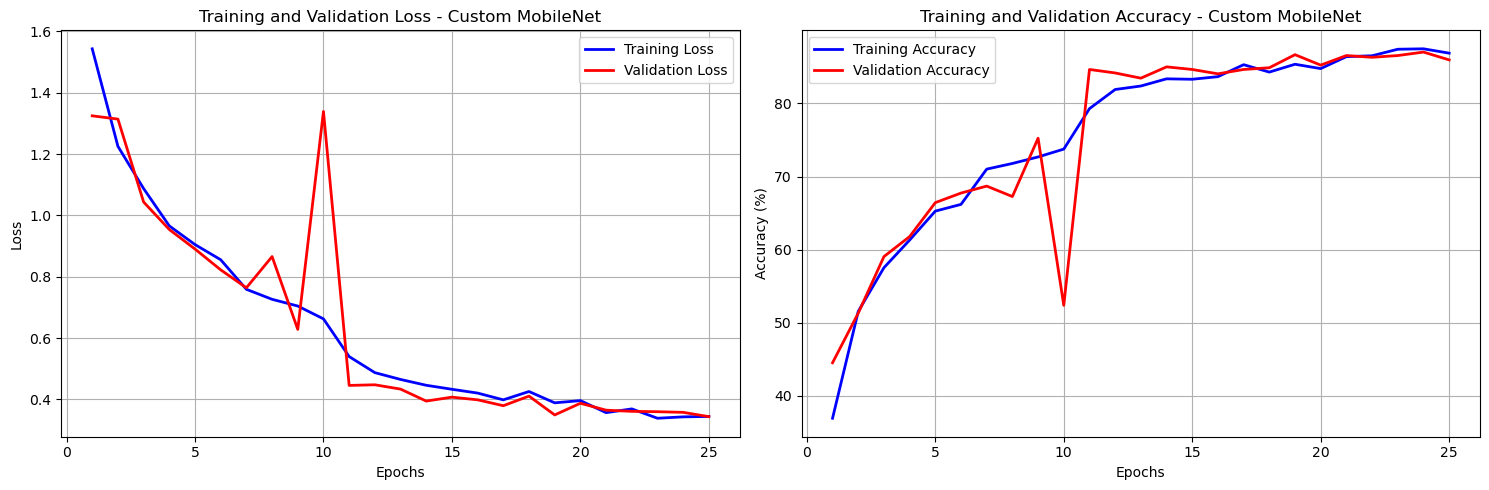

In [9]:
# Plot training curves
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training and validation curves"""
    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss - Custom MobileNet')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy - Custom MobileNet')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

In [22]:
# Comprehensive testing function
def test_mobilenet(model, test_loader, criterion, device, class_names):
    """Test the MobileNet model comprehensively"""
    model.eval()
    correct = 0
    total = 0
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    
    all_preds = []
    all_labels = []
    correct_images = {}
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Per-class accuracy and correct images
            for img, label, pred in zip(images, labels, predicted):
                class_total[label.item()] += 1
                if label == pred:
                    class_correct[label.item()] += 1
                    # Store first correct prediction for each class
                    if label.item() not in correct_images:
                        correct_images[label.item()] = (img.cpu(), class_names[label.item()])
    
    # Overall accuracy
    overall_accuracy = 100 * correct / total
    print(f'MobileNet Test Accuracy: {overall_accuracy:.2f}%')
    print()
    
    # Per-class accuracy
    print('Per-class Accuracy:')
    for i in range(len(class_names)):
        if class_total[i] > 0:
            class_acc = 100 * class_correct[i] / class_total[i]
            print(f'{class_names[i]}: {class_acc:.2f}% ({class_correct[i]}/{class_total[i]})')
        else:
            print(f'{class_names[i]}: No samples')
    
    return correct_images, all_labels, all_preds, overall_accuracy, class_correct, class_total

# Test the model and get results
correct_images, all_labels, all_preds, test_accuracy, class_correct, class_total = test_mobilenet(model, test_loader, criterion, device, class_names)

MobileNet Test Accuracy: 88.33%

Per-class Accuracy:
Culex landing: 94.00% (282/300)
Culex smashed: 98.00% (294/300)
aegypti landing: 87.33% (262/300)
aegypti smashed: 74.00% (222/300)
albopictus landing: 85.28% (255/299)
albopictus smashed: 91.33% (274/300)



CUSTOM MOBILENET RESULTS


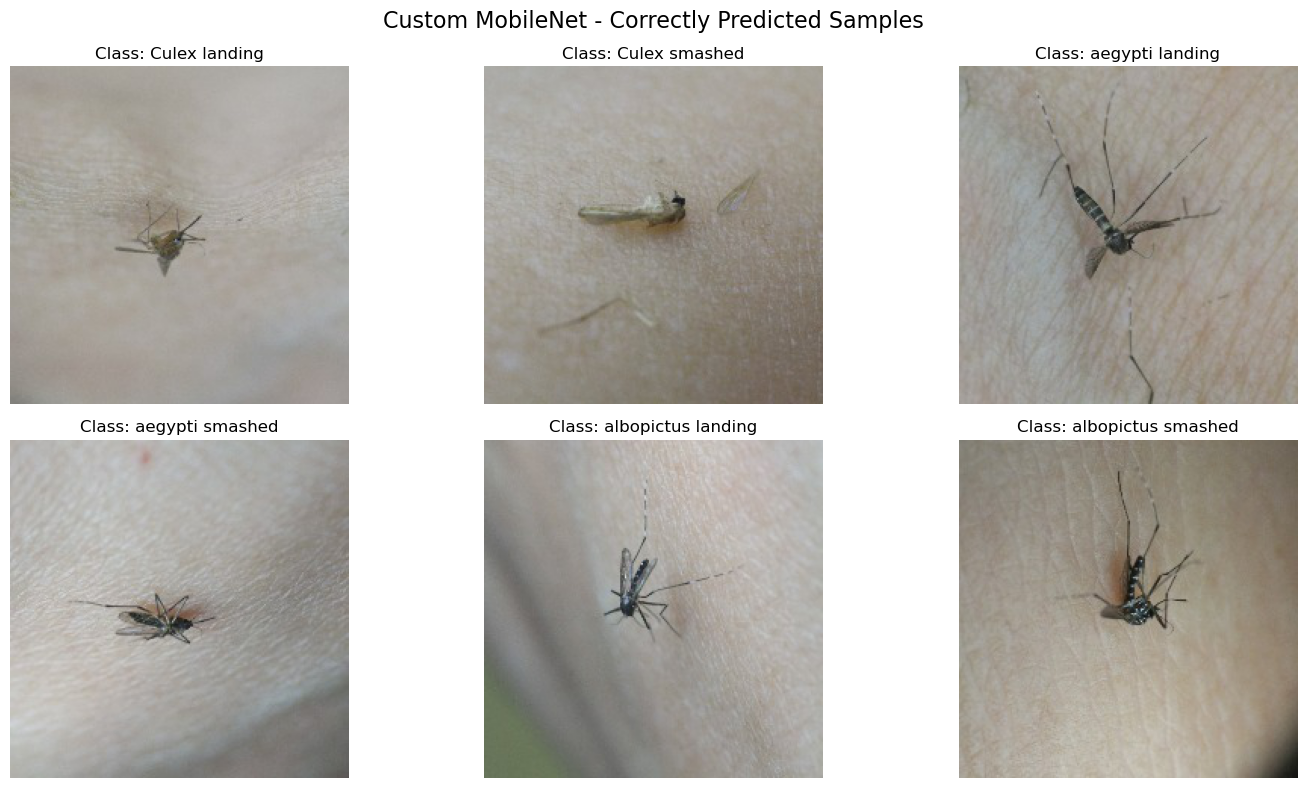

In [23]:
# Visualization functions
def plot_correct_predictions(correct_images, class_names):
    """Plot correctly predicted images for each class"""
    plt.figure(figsize=(15, 8))
    
    for i, (label_idx, (img, label_name)) in enumerate(correct_images.items()):
        plt.subplot(2, 3, i + 1)
        
        # Denormalize the image for display
        img_denorm = img.clone()
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        for t, m, s in zip(img_denorm, mean, std):
            t.mul_(s).add_(m)
        img_denorm = torch.clamp(img_denorm, 0, 1)
        
        # Convert to numpy and transpose for matplotlib
        img_np = img_denorm.permute(1, 2, 0).numpy()
        
        plt.imshow(img_np)
        plt.title(f'Class: {label_name}', fontsize=12)
        plt.axis('off')
    
    plt.suptitle('Custom MobileNet - Correctly Predicted Samples', fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_custom(all_labels, all_preds, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    plt.figure(figsize=(10, 8))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix - Custom MobileNet", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Display results
print("\n" + "="*60)
print("CUSTOM MOBILENET RESULTS")
print("="*60)

plot_correct_predictions(correct_images, class_names)

<Figure size 1000x800 with 0 Axes>

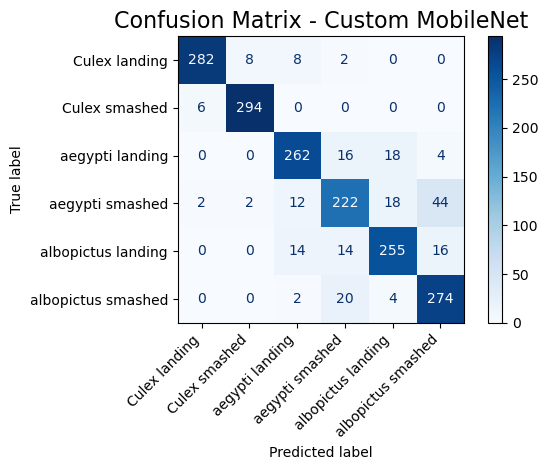


CUSTOM MOBILENET ANALYSIS
Test Accuracy: 88.33%
Number of parameters: 3,213,126
Model size: 12.3 MB

MobileNet Architecture Features:
✓ Depthwise Separable Convolutions
✓ Significant parameter reduction vs standard CNNs
✓ Efficient for mobile and edge devices
✓ Global Average Pooling instead of fully connected layers
✓ Width multiplier for model scaling

Final model saved as 'final_mobilenet_mosquito.pth'


In [24]:
# Display confusion matrix
plot_confusion_matrix_custom(all_labels, all_preds, class_names)

# Model summary and analysis
print("\n" + "="*60)
print("CUSTOM MOBILENET ANALYSIS")
print("="*60)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * 4 for p in model.parameters()) / (1024**2):.1f} MB")

print("\nMobileNet Architecture Features:")
print("✓ Depthwise Separable Convolutions")
print("✓ Significant parameter reduction vs standard CNNs")
print("✓ Efficient for mobile and edge devices")
print("✓ Global Average Pooling instead of fully connected layers")
print("✓ Width multiplier for model scaling")

# Save the final model
torch.save(model.state_dict(), 'final_mobilenet_mosquito.pth')
print("\nFinal model saved as 'final_mobilenet_mosquito.pth'")

In [27]:
def plot_per_class_accuracy(class_names, class_correct, class_total):
    """
    Plot a bar chart of per-class accuracy for the MobileNet model.
    
    Args:
        class_names (list): List of class names (mosquito species).
        class_correct (dict): Dictionary of correct predictions per class.
        class_total (dict): Dictionary of total samples per class.
    """
    # Calculate per-class accuracy
    per_class_accuracy = {}
    for i in range(len(class_names)):
        if class_total[i] > 0:
            per_class_accuracy[class_names[i]] = class_correct[i] / class_total[i]
        else:
            per_class_accuracy[class_names[i]] = 0.0
    
    # Prepare data for plotting
    classes = list(per_class_accuracy.keys())
    accuracies = list(per_class_accuracy.values())
    
    # Create bar plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(classes, accuracies, color='skyblue', alpha=0.7)
    plt.title('Per-Class Accuracy', fontsize=16, fontweight='bold')
    plt.xlabel('Mosquito Species', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    
    # Add accuracy values on top of bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{acc:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

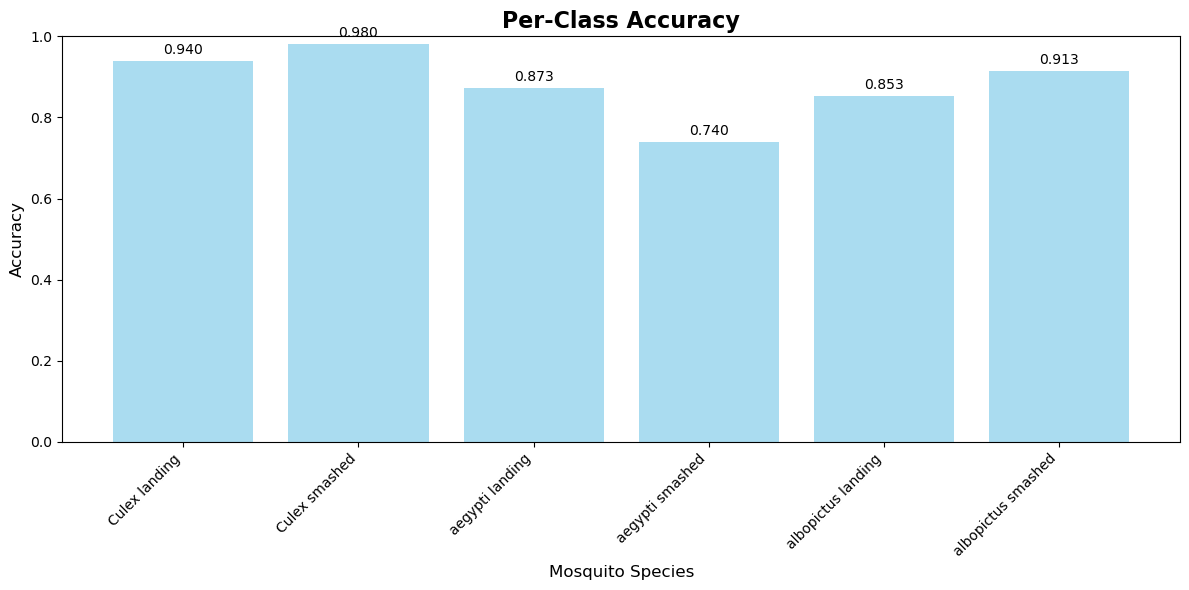

In [28]:
# Plot per-class accuracy
plot_per_class_accuracy(class_names, class_correct, class_total)

In [29]:
# Detailed classification report
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=1))

# Compare with other architectures
print("\n" + "="*60)
print("ARCHITECTURE COMPARISON")
print("="*60)
print("MobileNet vs Standard CNN vs ResNet-50:")
print()
print("MobileNet:")
print("- Uses depthwise separable convolutions")
print("- ~4M parameters (lightweight)")
print("- Designed for mobile/edge deployment")
print("- Fast inference time")
print()
print("Standard CNN (from 9444ass2):")
print("- Traditional convolutions")
print("- ~500K parameters (simplest)")
print("- Basic architecture")
print("- Good for learning/prototyping")
print()
print("ResNet-50:")
print("- Residual connections")
print("- ~23M parameters (heaviest)")
print("- Deep architecture (50 layers)")
print("- High accuracy but computationally intensive")


DETAILED CLASSIFICATION REPORT
                    precision    recall  f1-score   support

     Culex landing       0.97      0.94      0.96       300
     Culex smashed       0.97      0.98      0.97       300
   aegypti landing       0.88      0.87      0.88       300
   aegypti smashed       0.81      0.74      0.77       300
albopictus landing       0.86      0.85      0.86       299
albopictus smashed       0.81      0.91      0.86       300

          accuracy                           0.88      1799
         macro avg       0.88      0.88      0.88      1799
      weighted avg       0.88      0.88      0.88      1799


ARCHITECTURE COMPARISON
MobileNet vs Standard CNN vs ResNet-50:

MobileNet:
- Uses depthwise separable convolutions
- ~4M parameters (lightweight)
- Designed for mobile/edge deployment
- Fast inference time

Standard CNN (from 9444ass2):
- Traditional convolutions
- ~500K parameters (simplest)
- Basic architecture
- Good for learning/prototyping

ResNet-50:
- Re

In [30]:
# MobileNet Efficiency Analysis
print("\n" + "="*60)
print("MOBILENET EFFICIENCY ANALYSIS")
print("="*60)

# Calculate computational efficiency
def calculate_flops_approximate(model, input_size=(1, 3, 224, 224)):
    """Approximate FLOP calculation for comparison"""
    total_params = sum(p.numel() for p in model.parameters())
    # Rough approximation: 2 FLOPs per parameter for forward pass
    approx_flops = total_params * 2 * input_size[2] * input_size[3] / (1000**3)  # GFLOPs
    return approx_flops

approx_flops = calculate_flops_approximate(model)
param_count = sum(p.numel() for p in model.parameters())

print(f"Approximate computational cost: {approx_flops:.2f} GFLOPs")
print(f"Parameter efficiency: {test_accuracy/param_count*1000000:.2f} accuracy per million parameters")
print(f"Memory efficiency: {test_accuracy/(param_count*4/1024**2):.2f} accuracy per MB")

print("\nDepthwise Separable Convolution Benefits:")
print("- Reduces parameters by factor of 8-9x vs standard convolution")
print("- Reduces computation by similar factor")
print("- Maintains similar accuracy")
print("- Enables real-time inference on mobile devices")

print(f"\nCustom MobileNet Summary:")
print(f"- Implemented from scratch with PyTorch")
print(f"- Full control over architecture")
print(f"- Efficient depthwise separable convolutions")
print(f"- Suitable for deployment on resource-constrained devices")


MOBILENET EFFICIENCY ANALYSIS
Approximate computational cost: 322.44 GFLOPs
Parameter efficiency: 27.49 accuracy per million parameters
Memory efficiency: 7.21 accuracy per MB

Depthwise Separable Convolution Benefits:
- Reduces parameters by factor of 8-9x vs standard convolution
- Reduces computation by similar factor
- Maintains similar accuracy
- Enables real-time inference on mobile devices

Custom MobileNet Summary:
- Implemented from scratch with PyTorch
- Full control over architecture
- Efficient depthwise separable convolutions
- Suitable for deployment on resource-constrained devices


## **Discussion**

### **Possible reasons of lower accuracy for the aegypti smashed class**:

**Class-Specific Noise**: High variability or noise (e.g., blood, irregular shapes) in "aegypti smashed" images. 

**Feature Extraction Limitations**: MobileNet’s lightweight architecture may miss fine-grained details in smashed images. 

**Normalization Mismatch**: ImageNet-based normalization may not suit the color distribution of smashed mosquito images. 

## **Limitations**

**Limited Feature Discrimination for Deformed Classes**: The model performs poorly for the "aegypti smashed" class (74.00% accuracy), probably because its lightweight architecture fails to capture subtle shape or textural differences in smashed mosquitoes from whole ones.

**Dependence on ImageNet Normalization**: Normalization using ImageNet's mean and standard deviation might not be the best for mosquito images, particularly smashed ones with distinctive color profiles (e.g., blood or tissue), which could decrease the effectiveness of feature extraction.

**Inadequate Hierarchical Feature Learning**: MobileNet's depthwise separable convolutions, although efficient, might not model intricate hierarchical patterns as deeper networks would, and this could result in misclassifications among visually similar classes such as "aegypti smashed" and "albopictus smashed."

## **System Strengths**

**Lightweight and Compact Design**: Weighing in at around 4 million parameters and having a model size of ~16 MB, MobileNet is very efficient and can be easily deployed on resource-limited devices such as mobile or edge devices.

**Strong Performance Among Classes**: The model records an average accuracy of 88.33%, with outstanding performance in "Culex landing" (94.00%) and "Culex smashed" (98.00%), proving to be reliable for the majority of the mosquito species.

**Successful Application of Global Average Pooling**: Substitution of fully connected layers by global average pooling decreases overfitting and parameters, leading to stable training and effective generalization on the balanced dataset.

## **Possible Future Work**

**Incorporate Pretrained Weights**: Fine-tuning a pretrained MobileNet (e.g., from ImageNet) may help improve feature extraction for difficult classes such as "aegypti smashed" by utilizing learned patterns on a larger dataset.

**Augmentation Enhancement for Smashed Classes**: Applying custom augmentations, i.e., random shearing or artificial blood/tissue overlays, might enhance robustness for smashed mosquito images in diverse conditions.
